<a href="https://colab.research.google.com/github/fcignoli/Redes-Complejas-2-20222/blob/main/Borrador_de_TP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Librerias necesarias
#!pip install nltk
!pip install PyPDF2
!pip install bbox
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
!pip install igraph
!pip install python-louvain

import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import networkx as nx
from PyPDF2 import PdfReader
import re       # libreria de expresiones regulares
import pandas as pd
nltk.download('punkt') # if necessary...
nltk.download("stopwords")
import igraph as ig
from community import community_louvain as com
import cairo # Importo Cairo
import bbox
# Esto es para que funcione Cairo
from IPython.display import SVG, display, Image
def show_svg(file):
    display(SVG(filename=file))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 220 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.4-2ubuntu0.1).
libgif-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove a

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# PDF --> Texto --> Limpieza

In [3]:
def clean_text_round1(text):
    # pasa las mayusculas del texto a minusculas
    text = text.lower()
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    text = re.sub('\[.*?¿\]\%', ' ', text)
    # reemplaza singnos de puntuacion por espacio en blanco.. %s -> \S+ es cualquier caracter que no sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # remueve palabras que contienen numeros.
    text = re.sub('\w*\d\w*', '', text)
    return text

def clean_text_round2(text):
    # Sacamos comillas, los puntos suspensivos, <<, >>
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('–',"",text)
    text = re.sub('¿',"",text)
    return text

def pdfToText(filepath):
    """
    PDF ---> string
    """
    reader = PdfReader(filepath)
    number_of_pages = len(reader.pages)
    text = ''
    for i in range(number_of_pages):
        text+=reader.pages[i].extract_text()
    """
    Ahora limpiémoslo
    """
    text = clean_text_round1(text)
    text = clean_text_round2(text)
    return text
  

## TO-DO: ***textos*** ---> ***DataFrame***

In [4]:
import os #para trabajar con la carpeta donde están todos los pdfs
from google.colab import drive
drive.mount('/content/drive')
"""
Link al drive donde subí los ejemplos: https://drive.google.com/drive/folders/1VKAZsJ38SXsidJzHprzUsKXWrakzoZ4H?usp=share_link
"""

"""
función que carga los textos a un dataframe "df" con las columnas texto titulo autor y año
"""
df = pd.DataFrame({"Text":[],
            "Title":[],
            "Author":[],
            "Age":[]},)
def textToDataFrame(texto,titulo,autor,ano):
    return df.append({"Text": texto,
            "Title": titulo,
            "Author": autor,
            "Age": ano},
            ignore_index = True)

"""
La idea ahora es hacer un for loop que camine por nuestros archivos del drive donde están las obras
"""
for root, dirs, files in os.walk("/content/drive/My Drive/Literatura_Argentina"):
    for file in files:
        if file.endswith(".pdf"):
            if len(os.path.join(root, file).split("/")[-1].split("-")) == 3: # si la lista spliteada por '-' es igual a 3, es porque tiene atributo año.
              autor = os.path.join(root, file).split("/")[-1].split("-")[0]
              titulo = os.path.join(root, file).split("/")[-1].split("-")[1]
              ano = os.path.join(root, file).split("/")[-1].split("-")[-1].split(".")[0] #entonces le agregamos el atributo año
            else: # de lo contrario, le ponemos None
              autor = os.path.join(root, file).split("/")[-1].split("-")[0]
              titulo = os.path.join(root, file).split("/")[-1].split("-")[-1].split(".")[0]
              ano = None
            try: 
              texto = pdfToText(os.path.join(root,file))
              df = textToDataFrame(texto,titulo,autor,ano) 
            except:
              print(os.path.join(root,file))
              pass

Mounted at /content/drive
/content/drive/My Drive/Literatura_Argentina/Echeverria, Esteban - El Dogma Socialista De La Juventud Argentina.pdf
/content/drive/My Drive/Literatura_Argentina/Echeverria, Esteban - Himno Al Dolor.pdf
/content/drive/My Drive/Literatura_Argentina/Sarmiento, Domingo F - Argirópolis - 1850.pdf
/content/drive/My Drive/Literatura_Argentina/Sarmiento, Domingo Faustino - Facundo - 1845.pdf


In [ ]:
df

Text  \
0   jorge luis borges ficciones   el aleph el info...   
1                                                 ...   
2   la autopsia de creso                          ...   
3      adolfo bioy casares     probablemente fue c...   
4   el caso de los viejitos voladores  adolfo bioy...   
..                                                ...   
68  cuántos segundos estuvo dem psey fuera de comb...   
69    cuando parece  que la tranquilidad ha vuelto...   
70  este es el nuev o e impactante libro de cuento...   
71  en el verano de  una niña —perspicaz  observad...   
72  el secreto de la residencia maguire  secreto d...   

                                         Title  \
0    Ficciones, El Aleph, El Informe de Brodie   
1                  La vuelta de Martin Fierro    
2                        La Autopsia De Creso    
3                                     Noumeno    
4           El Caso De Los Viejitos Voladores    
..                                         ...   
68                            Segundos afuera    
69                                    Betibú    
70                                  Quién no    
71               Un comunista en calzoncillos    
72                                         GC    

                                  Author    Age  
0                     Jorge Luis Borges    None  
1                        Jose Hernandez    1879  
2                    Marechal, Leopoldo    1965  
3                  Bioy, Casares Adolfo    1965  
4                  Bioy, Casares Adolfo    1949  
..                                   ...    ...  
68                        Martín Kohan    2005  
69                    Piñeiro, Claudia    2011  
70                     Claudia Piñeiro    2018  
71                     Claudia Piñeiro    2013  
72  El Secreto de la Residencia Maguire    2022  

[73 rows x 4 columns]

# De ***textos*** a ***redes***

## De ***Textos*** a ***Redes*** 
versión Gian

(64092, 11)


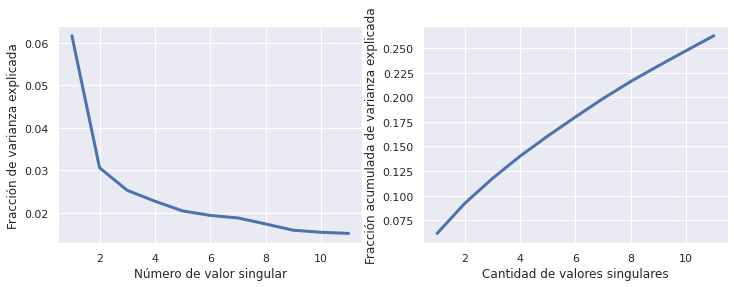

In [5]:
# Objetos de sklearn para hacer LSA
from sklearn.feature_extraction.text import CountVectorizer # Contador de frecuencia
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf
from sklearn.decomposition import TruncatedSVD # Singular Value Decomposition
# Lista de stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
from scipy.spatial.distance import cosine as cosine_distance
import heapq
# Creamos el objeto contador de palabras, pidiéndole que remueve
# las stopwords, los términos que aparecen en un único documento (min_df)
# y los términos que aparecen en más del 70% de los documentos (max_df).
# Esto es para eliminar palabras raras (o errores de tipeo) y
# términos que seguramente son stopwords no incluídos en la lista
count = CountVectorizer(min_df = 2, max_df = 0.70, stop_words = stopwords)

# Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(df['Text'])

# Dimensions de la matriz doc-tér
# print(x_count.shape)

# Creamos el objeto tf-idf. Le decimos además que devuelva los
# vectores documento con norma euclídea igual a 1 (norm = 'l2')
tfidf = TfidfTransformer(norm = 'l2')

# Creamos la matriz tf-idf a partir de la matriz de frecuencias
x_tfidf = tfidf.fit_transform(x_count)

# Dimensión del espacio reducido
n_components = 11

# Creación del objeto SVD
svd = TruncatedSVD(n_components = n_components)

# Ajuste con los datos y descripción en el espacio reducido
# Trabajamos con la matriz traspuesta
x_svd = svd.fit_transform(x_tfidf.T)

# Dimensión de la matriz de datos en el espacio reducido
print(x_svd.shape)

# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = svd.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '-', linewidth = 3)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de valor singular')

# Calculamos el acumulado con la función cumsum de numpy
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', linewidth = 3)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de valores singulares')
plt.show()




In [6]:
from sklearn.feature_extraction import DictVectorizer

text = list(count.get_feature_names_out())
text


['ab',
 'aba',
 'ababa',
 'abadía',
 'abaj',
 'abajaba',
 'abajó',
 'abalanza',
 'abalanzaba',
 'abalanzaban',
 'abalanzado',
 'abalanzan',
 'abalanzarse',
 'abalanzándose',
 'abalanzó',
 'aballo',
 'aballos',
 'abalorios',
 'aban',
 'aband',
 'abanderada',
 'abando',
 'abandon',
 'abandona',
 'abandonaba',
 'abandonaban',
 'abandonada',
 'abandonadas',
 'abandonado',
 'abandonados',
 'abandonamos',
 'abandonan',
 'abandonando',
 'abandonar',
 'abandonara',
 'abandonaran',
 'abandonarla',
 'abandonarlo',
 'abandonarlos',
 'abandonarme',
 'abandonarnos',
 'abandonaron',
 'abandonaría',
 'abandonase',
 'abandonaste',
 'abandone',
 'abandonen',
 'abandones',
 'abandono',
 'abandonáis',
 'abandonándose',
 'abandoné',
 'abandonó',
 'abanica',
 'abanicaba',
 'abanican',
 'abanico',
 'abanicos',
 'abanicándose',
 'abanicó',
 'abar',
 'abarca',
 'abarcaba',
 'abarcable',
 'abarcado',
 'abarcadora',
 'abarcan',
 'abarcando',
 'abarcar',
 'abarcara',
 'abarcó',
 'abarrotada',
 'abarrotado',
 'ab

In [7]:
labels_autores = {}
labels_año = {}
labels_titulos={}
for i in df.index:
  labels_autores.update({i:df['Author'][i]}) #Creamos un diccionario de índice - autor
  labels_año.update({i:df['Age'][i]})# índice - año
  labels_titulos.update({i:df['Title'][i]})# índice - titulos




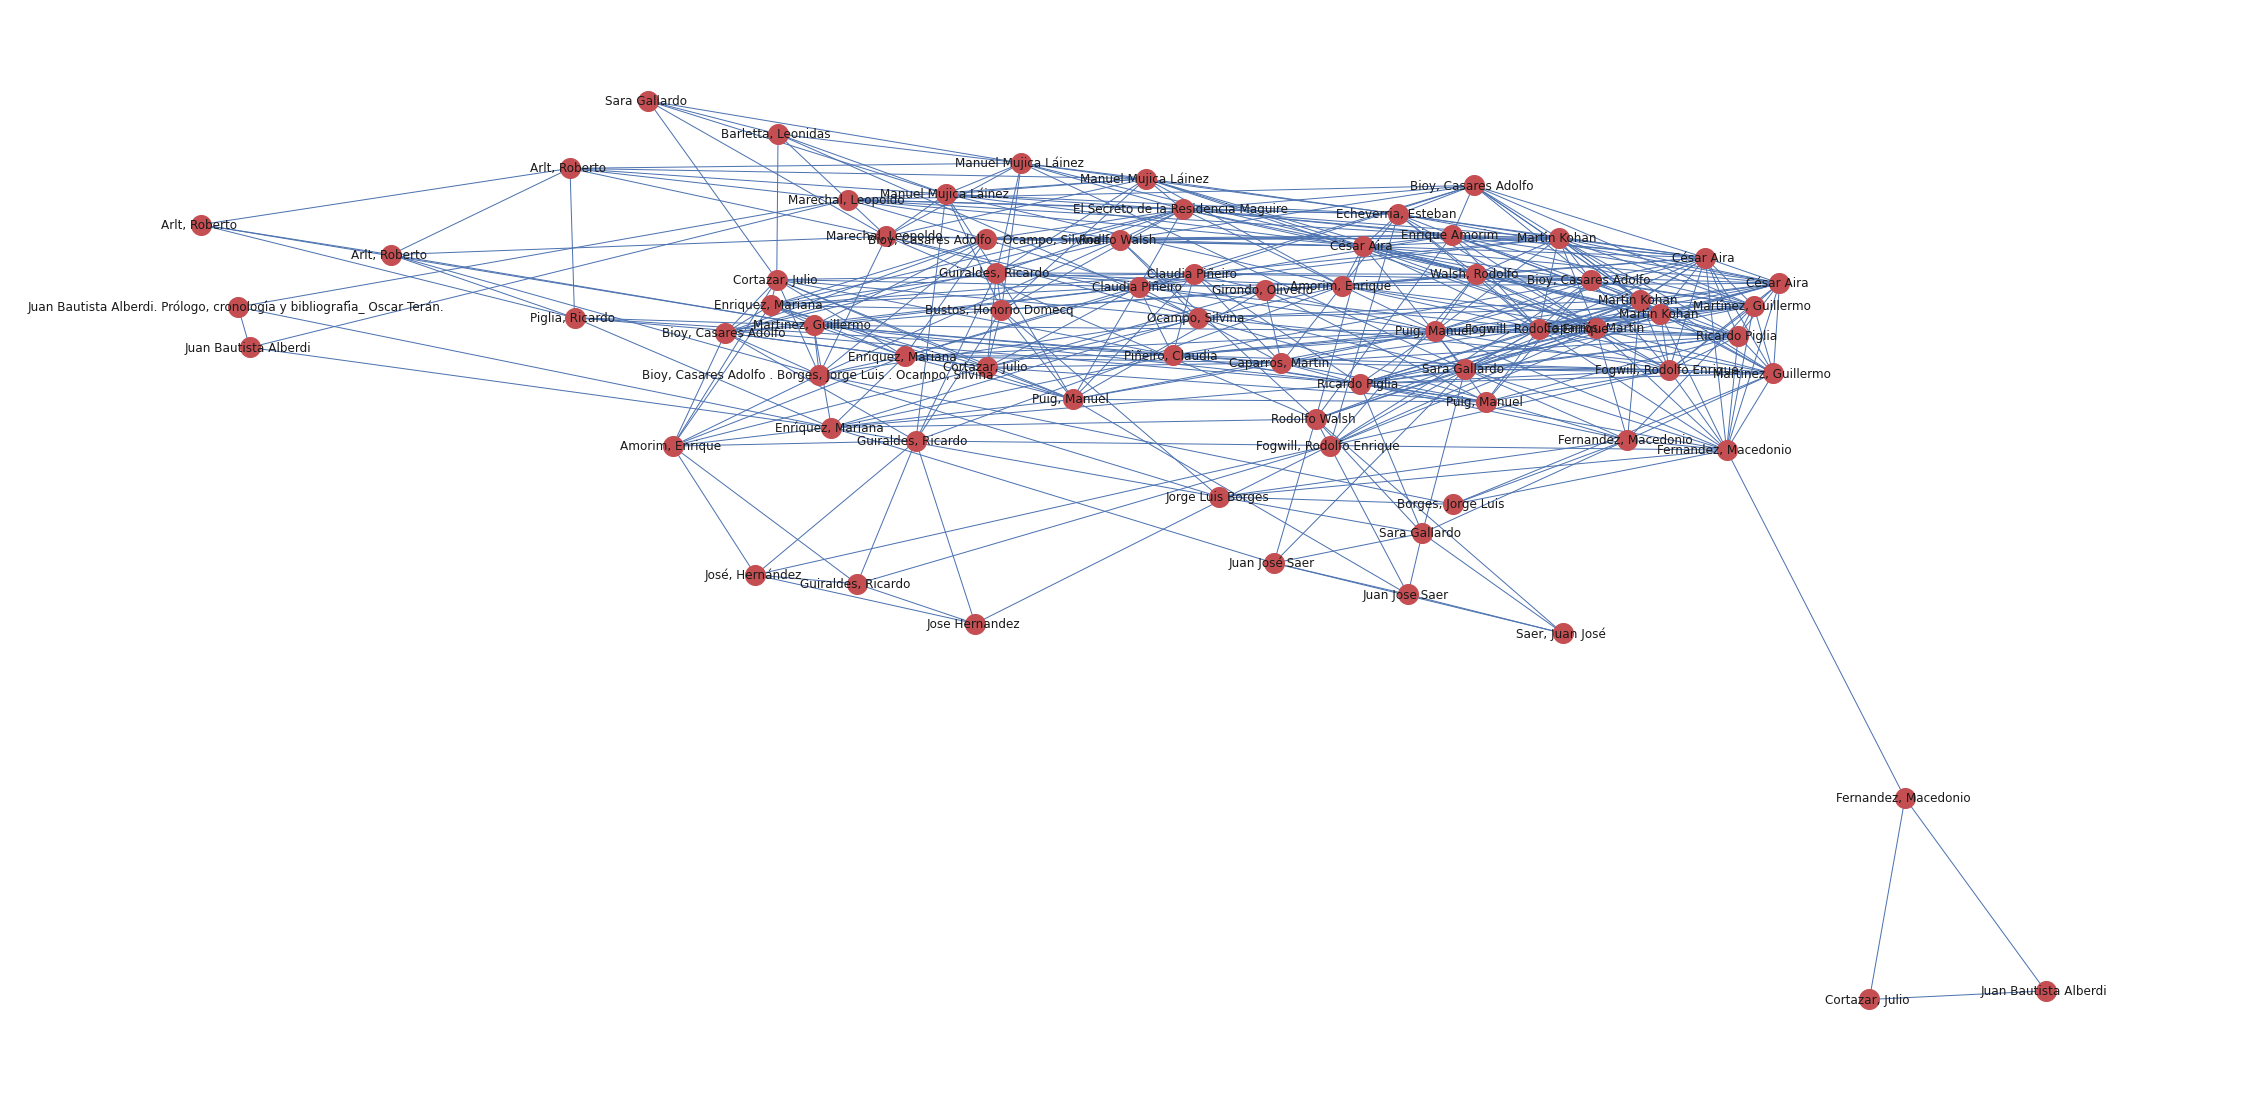

In [8]:
red = []
for i in df['Text']:
    index = df[df['Text'] == i].index[0]
    similarities = [1.00 - cosine_distance(svd.components_.T[index], svd.components_.T[i]) for i in range(svd.components_.shape[1])]
    red.append(similarities)

matriz = np.array(red)

matriz = (1+matriz)/2
matriz[matriz < .695] = 0 # los que tienen una similaridad menor a 0.8, ledamos 0 El valor optimo es .7275
matriz[matriz == 1] = 0
matriz[matriz >= .695] = 1 # los que tienen una similaridad mayor a 0.05, le damos 1. de esta manera lo binarizamos

G = nx.from_numpy_matrix(matriz, create_using = nx.Graph)

#pos = nx.layout.fruchterman_reingold_layout(G)

pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize = (40, 20))
ax.axis('off')
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=400)
nx.draw_networkx_edges(G, pos, edge_color='b')
nx.draw_networkx_labels(G, pos, labels_autores, font_size=12)

#nx.draw(G, with_labels=True)
plt.show()



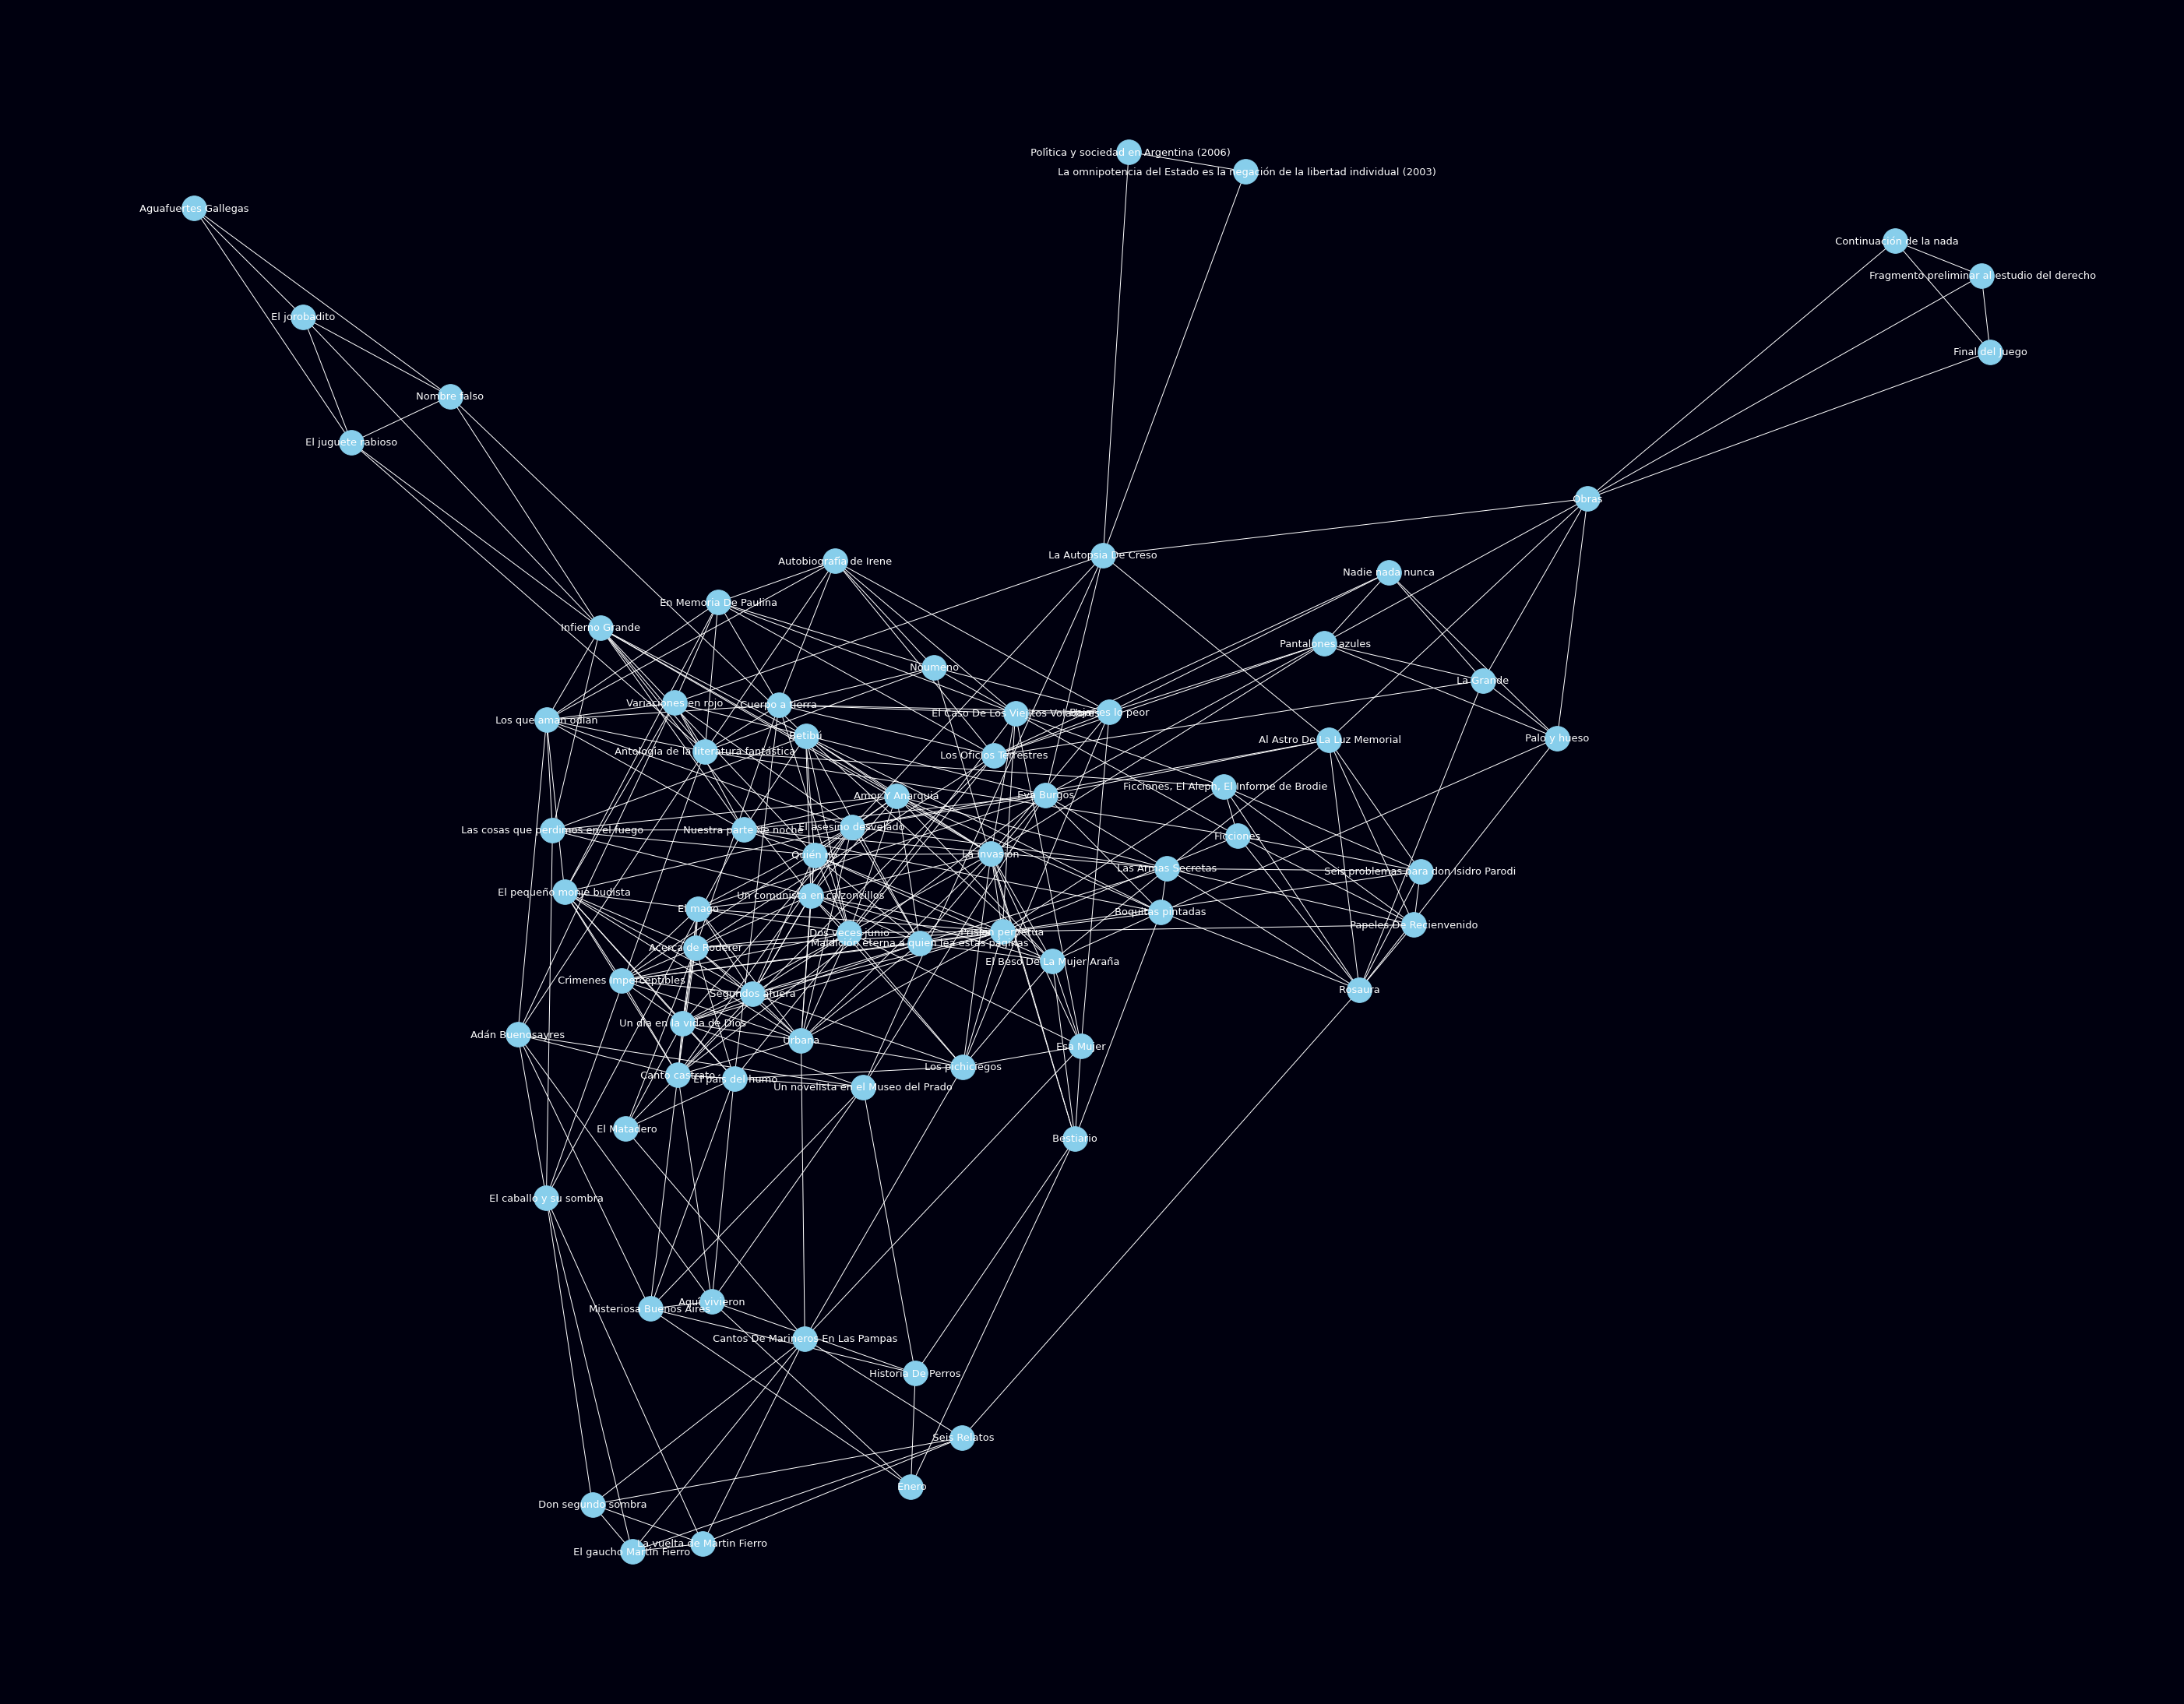

In [ ]:
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize = (50, 40))
ax.axis('off')
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)
nx.draw_networkx_edges(G, pos, edge_color='white')
nx.draw_networkx_labels(G, pos, labels_titulos, font_size=13, font_color='white')
fig.set_facecolor("#00000F")
#nx.draw(G, with_labels=True)
plt.show()

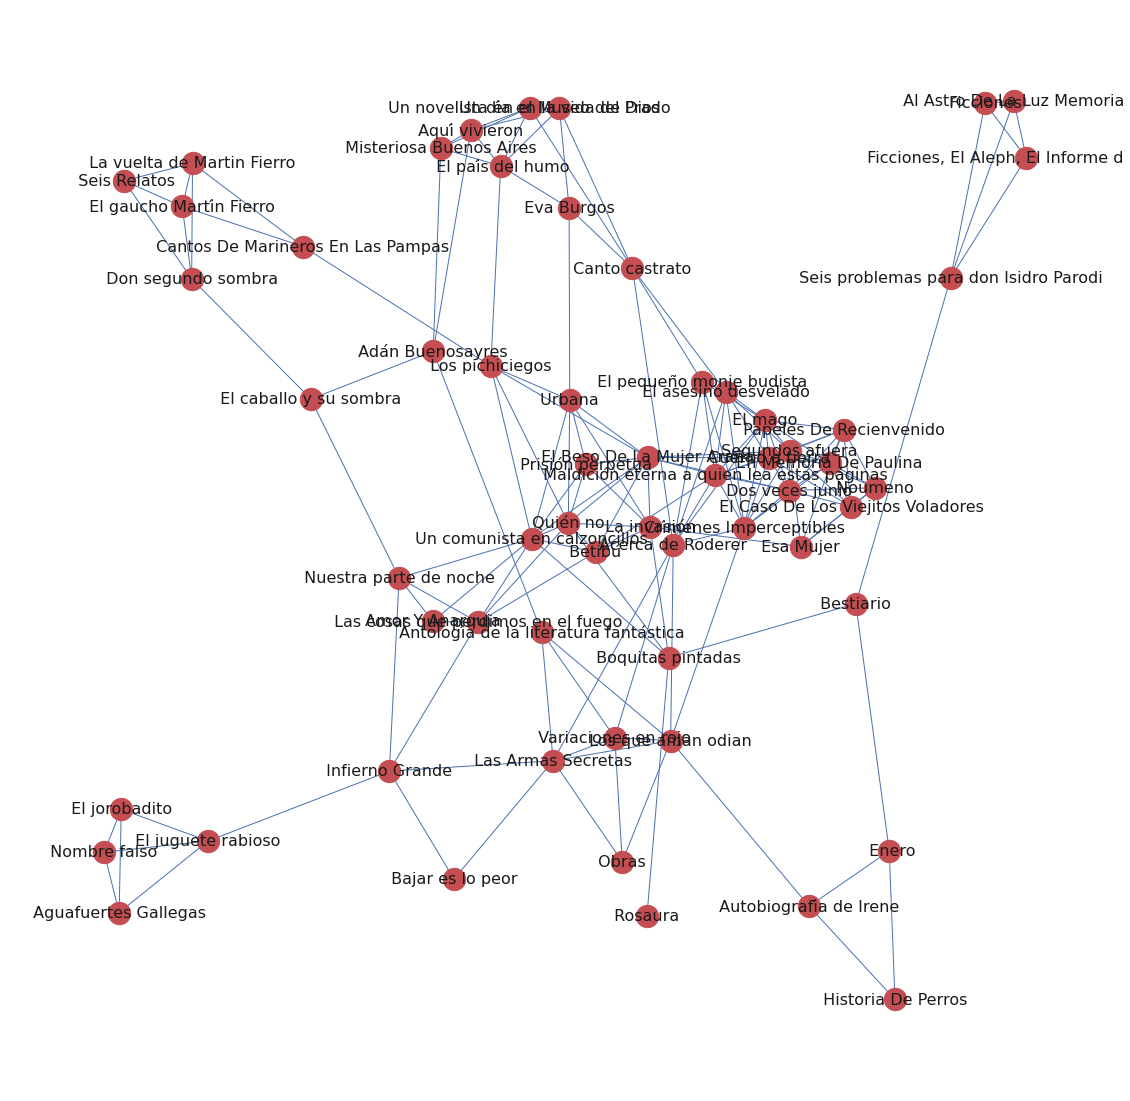

In [ ]:
componentes= nx.connected_components(G) #tomamos las componentes de la
lista_componentes = [G.subgraph(componente) for componente in 
                     sorted(componentes, key=len, reverse=True)]
G_gigante= lista_componentes[0] #Tomo la componente gigante

fig, ax = plt.subplots(figsize = (20, 20))
ax.axis('off')
nx.draw_networkx_nodes(G_gigante, pos, node_color='r', node_size=500)
nx.draw_networkx_edges(G_gigante, pos, edge_color='b')
nx.draw_networkx_labels(G_gigante, pos, labels_titulos, font_size=16)

plt.show()

In [ ]:
grados = G.degree()
dic = list(dict(grados).values())
dic.index(7)
df['Author'][24]
diametr = nx.diameter(G_gigante)

# Fastgreedy 

G_ig = ig.Graph.from_networkx(G_gigante)
com_fg = G_ig.community_fastgreedy(weights = None)
print(com_fg) # Cantidad de elementos y de mergeos hechos
print(f'La cantidad de comunas que maximiza la modularidad es: {com_fg.optimal_count}')
print(f'La modularidad de dicha partición es: {com_fg.as_clustering().modularity}')
print(f'La separación en comunas, considerando 5 comunidades es: \n {com_fg.as_clustering()}')

Dendrogram, 60 elements, 59 merges
La cantidad de comunas que maximiza la modularidad es: 7
La modularidad de dicha partición es: 0.6300091827364555
La separación en comunas, considerando 5 comunidades es: 
 Clustering with 60 elements and 7 clusters
[0] 0, 5, 17, 25, 26, 27, 31, 41
[1] 1, 8, 9, 19, 20, 29
[2] 2, 3, 4, 7, 18, 28, 37, 50, 51, 53, 54, 55, 56
[3] 6, 10, 13, 23, 24, 32, 33, 34
[4] 11, 12, 30, 35, 36, 38, 46, 47, 48, 49, 57, 58, 59
[5] 14, 15, 16, 45
[6] 21, 22, 39, 40, 42, 43, 44, 52


Clustering with 60 elements and 9 clusters
[0] 0, 5, 17, 27
[1] 1, 8, 9, 20, 29
[2] 2, 3, 4, 7, 10, 18, 28, 37, 50, 51, 53, 54, 55, 56
[3] 6, 19, 34, 35, 36, 38
[4] 11, 12, 30, 46, 47, 48, 49, 57, 58, 59
[5] 13, 23, 24, 32, 33
[6] 14, 15, 16, 45
[7] 21, 22, 39, 40, 42, 43, 44, 52
[8] 25, 26, 31, 41


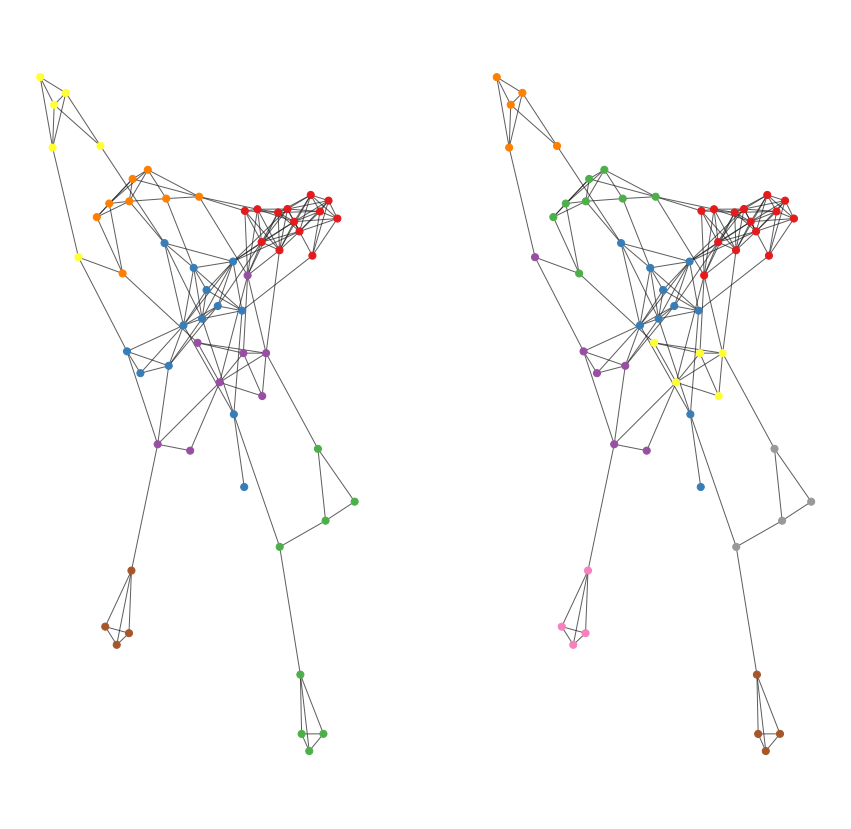

In [ ]:
# Infomap

com_ip = G_ig.community_infomap()

print(com_ip)

# Función para llevar el objeto vertex cluster a diccionario
def cluster_to_dict(cluster, g):
    dic = {}
    for i, c in enumerate(sorted(list(cluster), key = len, reverse = True)):
        for n in c:
            dic[g.vs[n]['_nx_name']] = i
    return dic

pos = nx.layout.fruchterman_reingold_layout(G_gigante)

dic_com_fg = cluster_to_dict(com_fg.as_clustering(), G_ig)
dic_com_ip = cluster_to_dict(com_ip, G_ig)
particiones = [dic_com_fg, dic_com_ip]

fig, axs = plt.subplots(1, 2, figsize = (15, 15))

for i, ax in enumerate(fig.axes):
    nx.draw_networkx_nodes(G_gigante,
                           pos = pos,
                           node_color = [plt.get_cmap('Set1')(particiones[i][v]) for v in G_gigante.nodes()],
                           ax = ax,
                           node_size = 50)
    nx.draw_networkx_edges(G_gigante,
                           pos = pos,
                           ax = ax,
                           alpha = .7)
    ax.axis('off')
plt.show()

plt.show()

In [9]:
#centralidad y letalidad


def abrir_esenciales(nombre_archivo):
    archivo = open(nombre_archivo)
    data = []
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)  
    data = data[2:]
    esenciales = []
    for linea in data:
      if len(linea)>2:
        esenciales.append(linea[1])
    return(esenciales)


def segundo_elemento(lista):
  return lista[1]

def hacer_lista_grados_ordenada(Red):
  grados = Red.degree()
  grados = list(grados)
  grados.sort(key = segundo_elemento, reverse = True)
  return [nodo for (nodo,grado) in grados]

def ordenar_diccionario_por_valor(diccionario):
  return [key for key, value in sorted(diccionario.items(), key=lambda item: item[1], reverse=True)]



In [10]:
Red = G.copy()
diccionario_centralidad_grado = nx.degree_centrality(Red)
diccionario_centralidad_intermediatez = nx.betweenness_centrality(Red, k=None, normalized=True, weight=None, endpoints=False, seed=None)
diccionario_centralidad_autovalor = nx.eigenvector_centrality(Red, max_iter=100, tol=1e-06, nstart=None, weight='weight')
diccionario_centralidad_cercania = nx.closeness_centrality(Red, u=None, distance=None, wf_improved=True)


def sacar_max_centralidad_degree(Red):
  # Calcula la centralidad de autovalor
  centralidad = nx.degree_centrality(Red)
  # Devuelve el nodo de máxima centralidad
  return max(centralidad, key=centralidad.get)

def sacar_max_centralidad_betweenness(Red):
  # Calcula la centralidad de autovalor
  centralidad = nx.betweenness_centrality(Red, k=None, normalized=True, weight=None, endpoints=False, seed=None)
  # Devuelve el nodo de máxima centralidad
  return max(centralidad, key=centralidad.get)

def sacar_max_centralidad_eigenvalue(Red):
  # Calcula la centralidad de autovalor
  centralidad = nx.eigenvector_centrality(Red, max_iter=100, tol=1e-06, nstart=None, weight='weight')
  # Devuelve el nodo de máxima centralidad
  return max(centralidad, key=centralidad.get)

def sacar_max_centralidad_closeness(Red):
  # Calcula la centralidad de autovalor
  centralidad = nx.closeness_centrality(Red, u=None, distance=None, wf_improved=True)
  # Devuelve el nodo de máxima centralidad
  return max(centralidad, key=centralidad.get)

print(sacar_max_centralidad_degree(G))
print(sacar_max_centralidad_betweenness(G))
print(sacar_max_centralidad_eigenvalue(G))
print(sacar_max_centralidad_closeness(G))


36
30
36
36


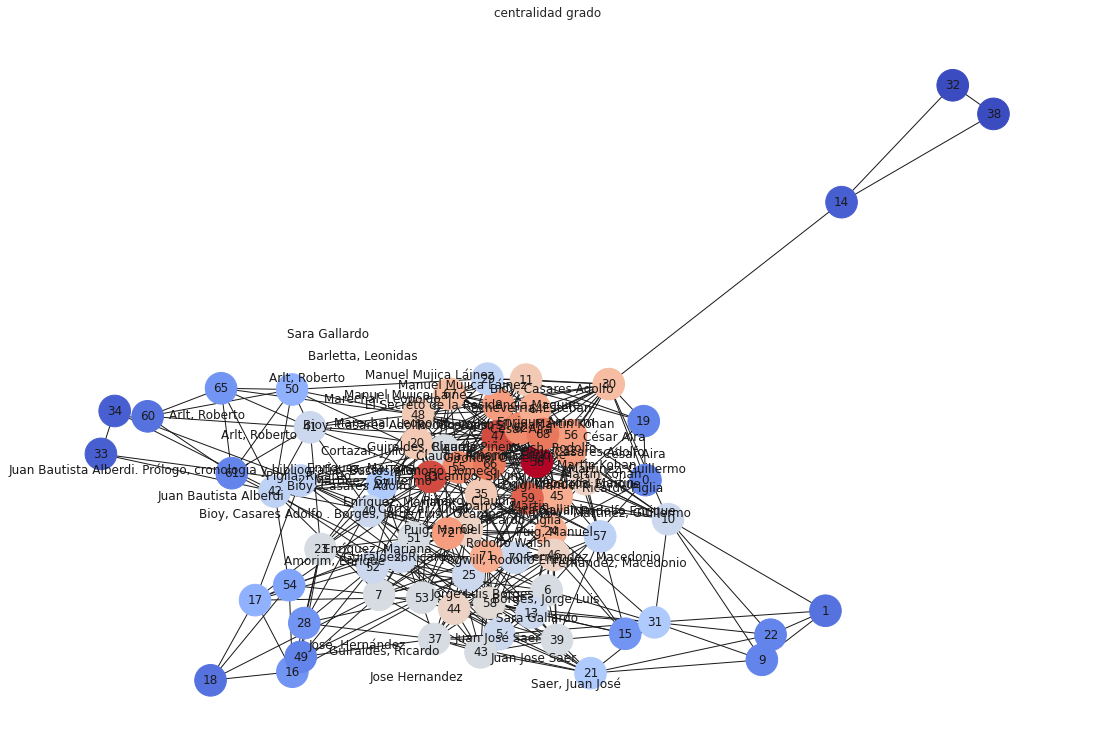

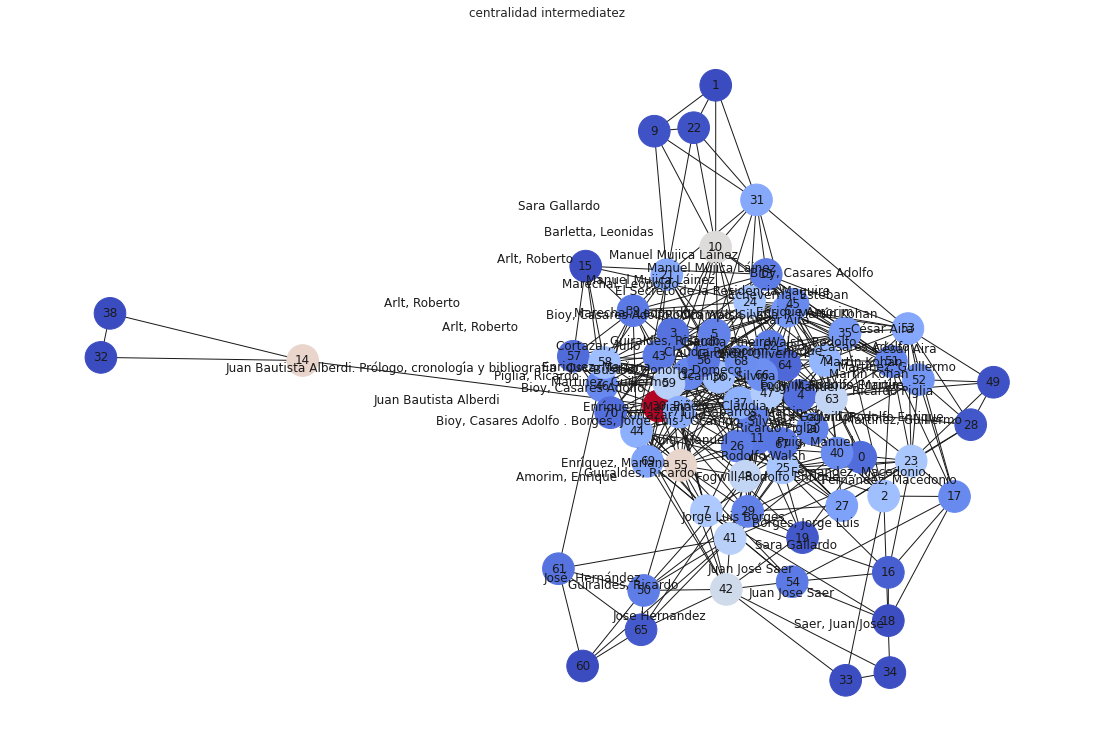

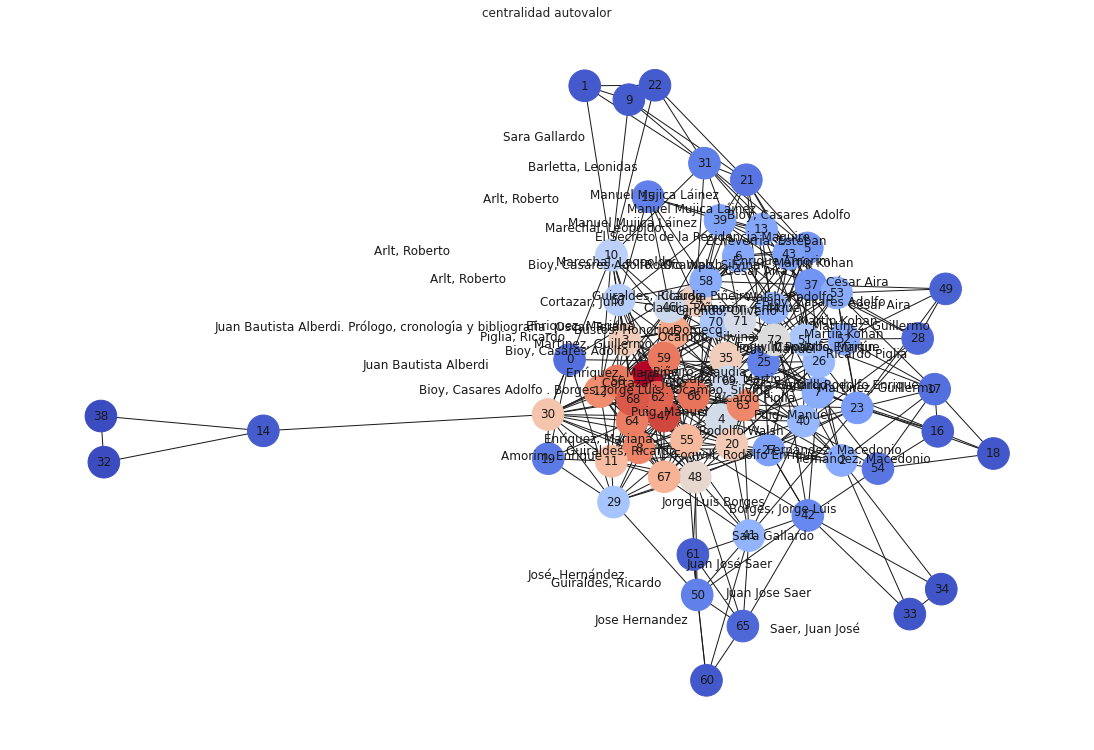

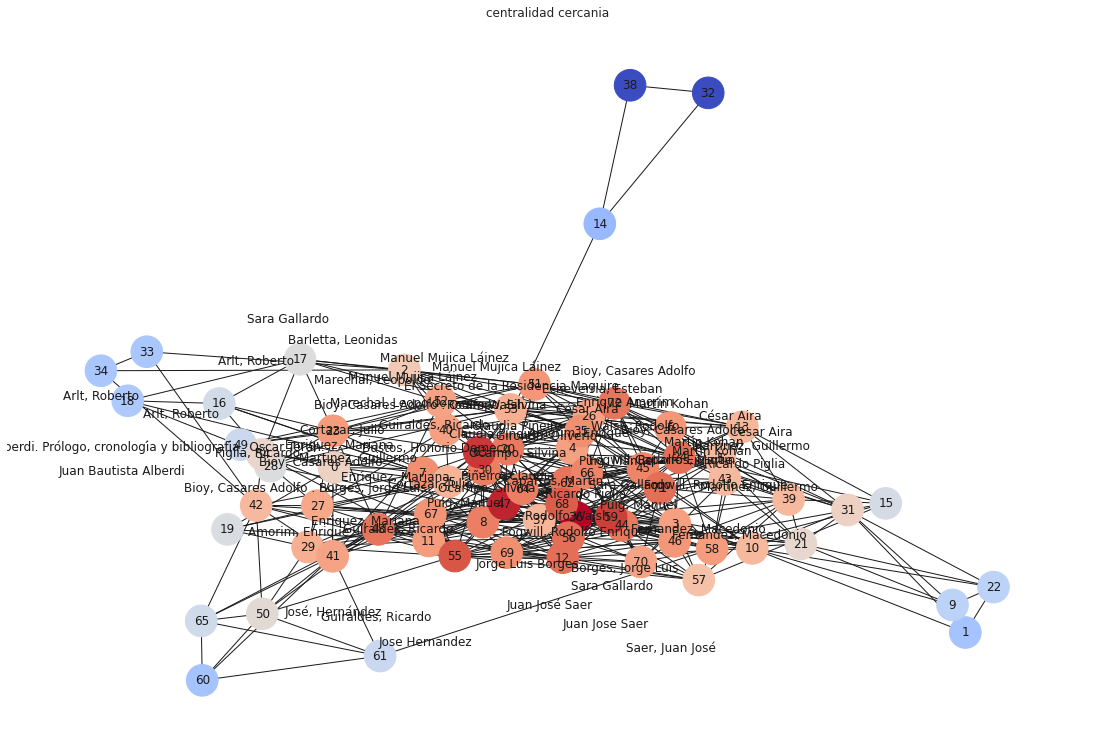

In [13]:
import matplotlib as mpl
from pylab import rcParams
#grafiquemos
color_lookup=diccionario_centralidad_grado
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)

rcParams['figure.figsize'] = 15, 10
nx.draw(G, 
        nodelist=color_lookup,
        node_size=1000,
        node_color=[mapper.to_rgba(i) 
                    for i in color_lookup.values()], 
        with_labels=True)
nx.draw_networkx_labels(G, pos, labels_autores, font_size=12)
plt.title('centralidad grado')
plt.show()


color_lookup=diccionario_centralidad_intermediatez
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)

rcParams['figure.figsize'] = 15, 10
nx.draw(G, 
        nodelist=color_lookup,
        node_size=1000,
        node_color=[mapper.to_rgba(i) 
                    for i in color_lookup.values()], 
        with_labels=True)
nx.draw_networkx_labels(G, pos, labels_autores, font_size=12)
plt.title('centralidad intermediatez')
plt.show()


color_lookup=diccionario_centralidad_autovalor
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)

rcParams['figure.figsize'] = 15, 10
nx.draw(G, 
        nodelist=color_lookup,
        node_size=1000,
        node_color=[mapper.to_rgba(i) 
                    for i in color_lookup.values()], 
        with_labels=True)
nx.draw_networkx_labels(G, pos, labels_autores, font_size=12)
plt.title('centralidad autovalor')
plt.show()


color_lookup=diccionario_centralidad_cercania
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)

rcParams['figure.figsize'] = 15, 10
nx.draw(G, 
        nodelist=color_lookup,
        node_size=1000,
        node_color=[mapper.to_rgba(i) 
                    for i in color_lookup.values()], 
        with_labels=True)
nx.draw_networkx_labels(G, pos, labels_autores, font_size=12)
plt.title('centralidad cercania')
plt.show()

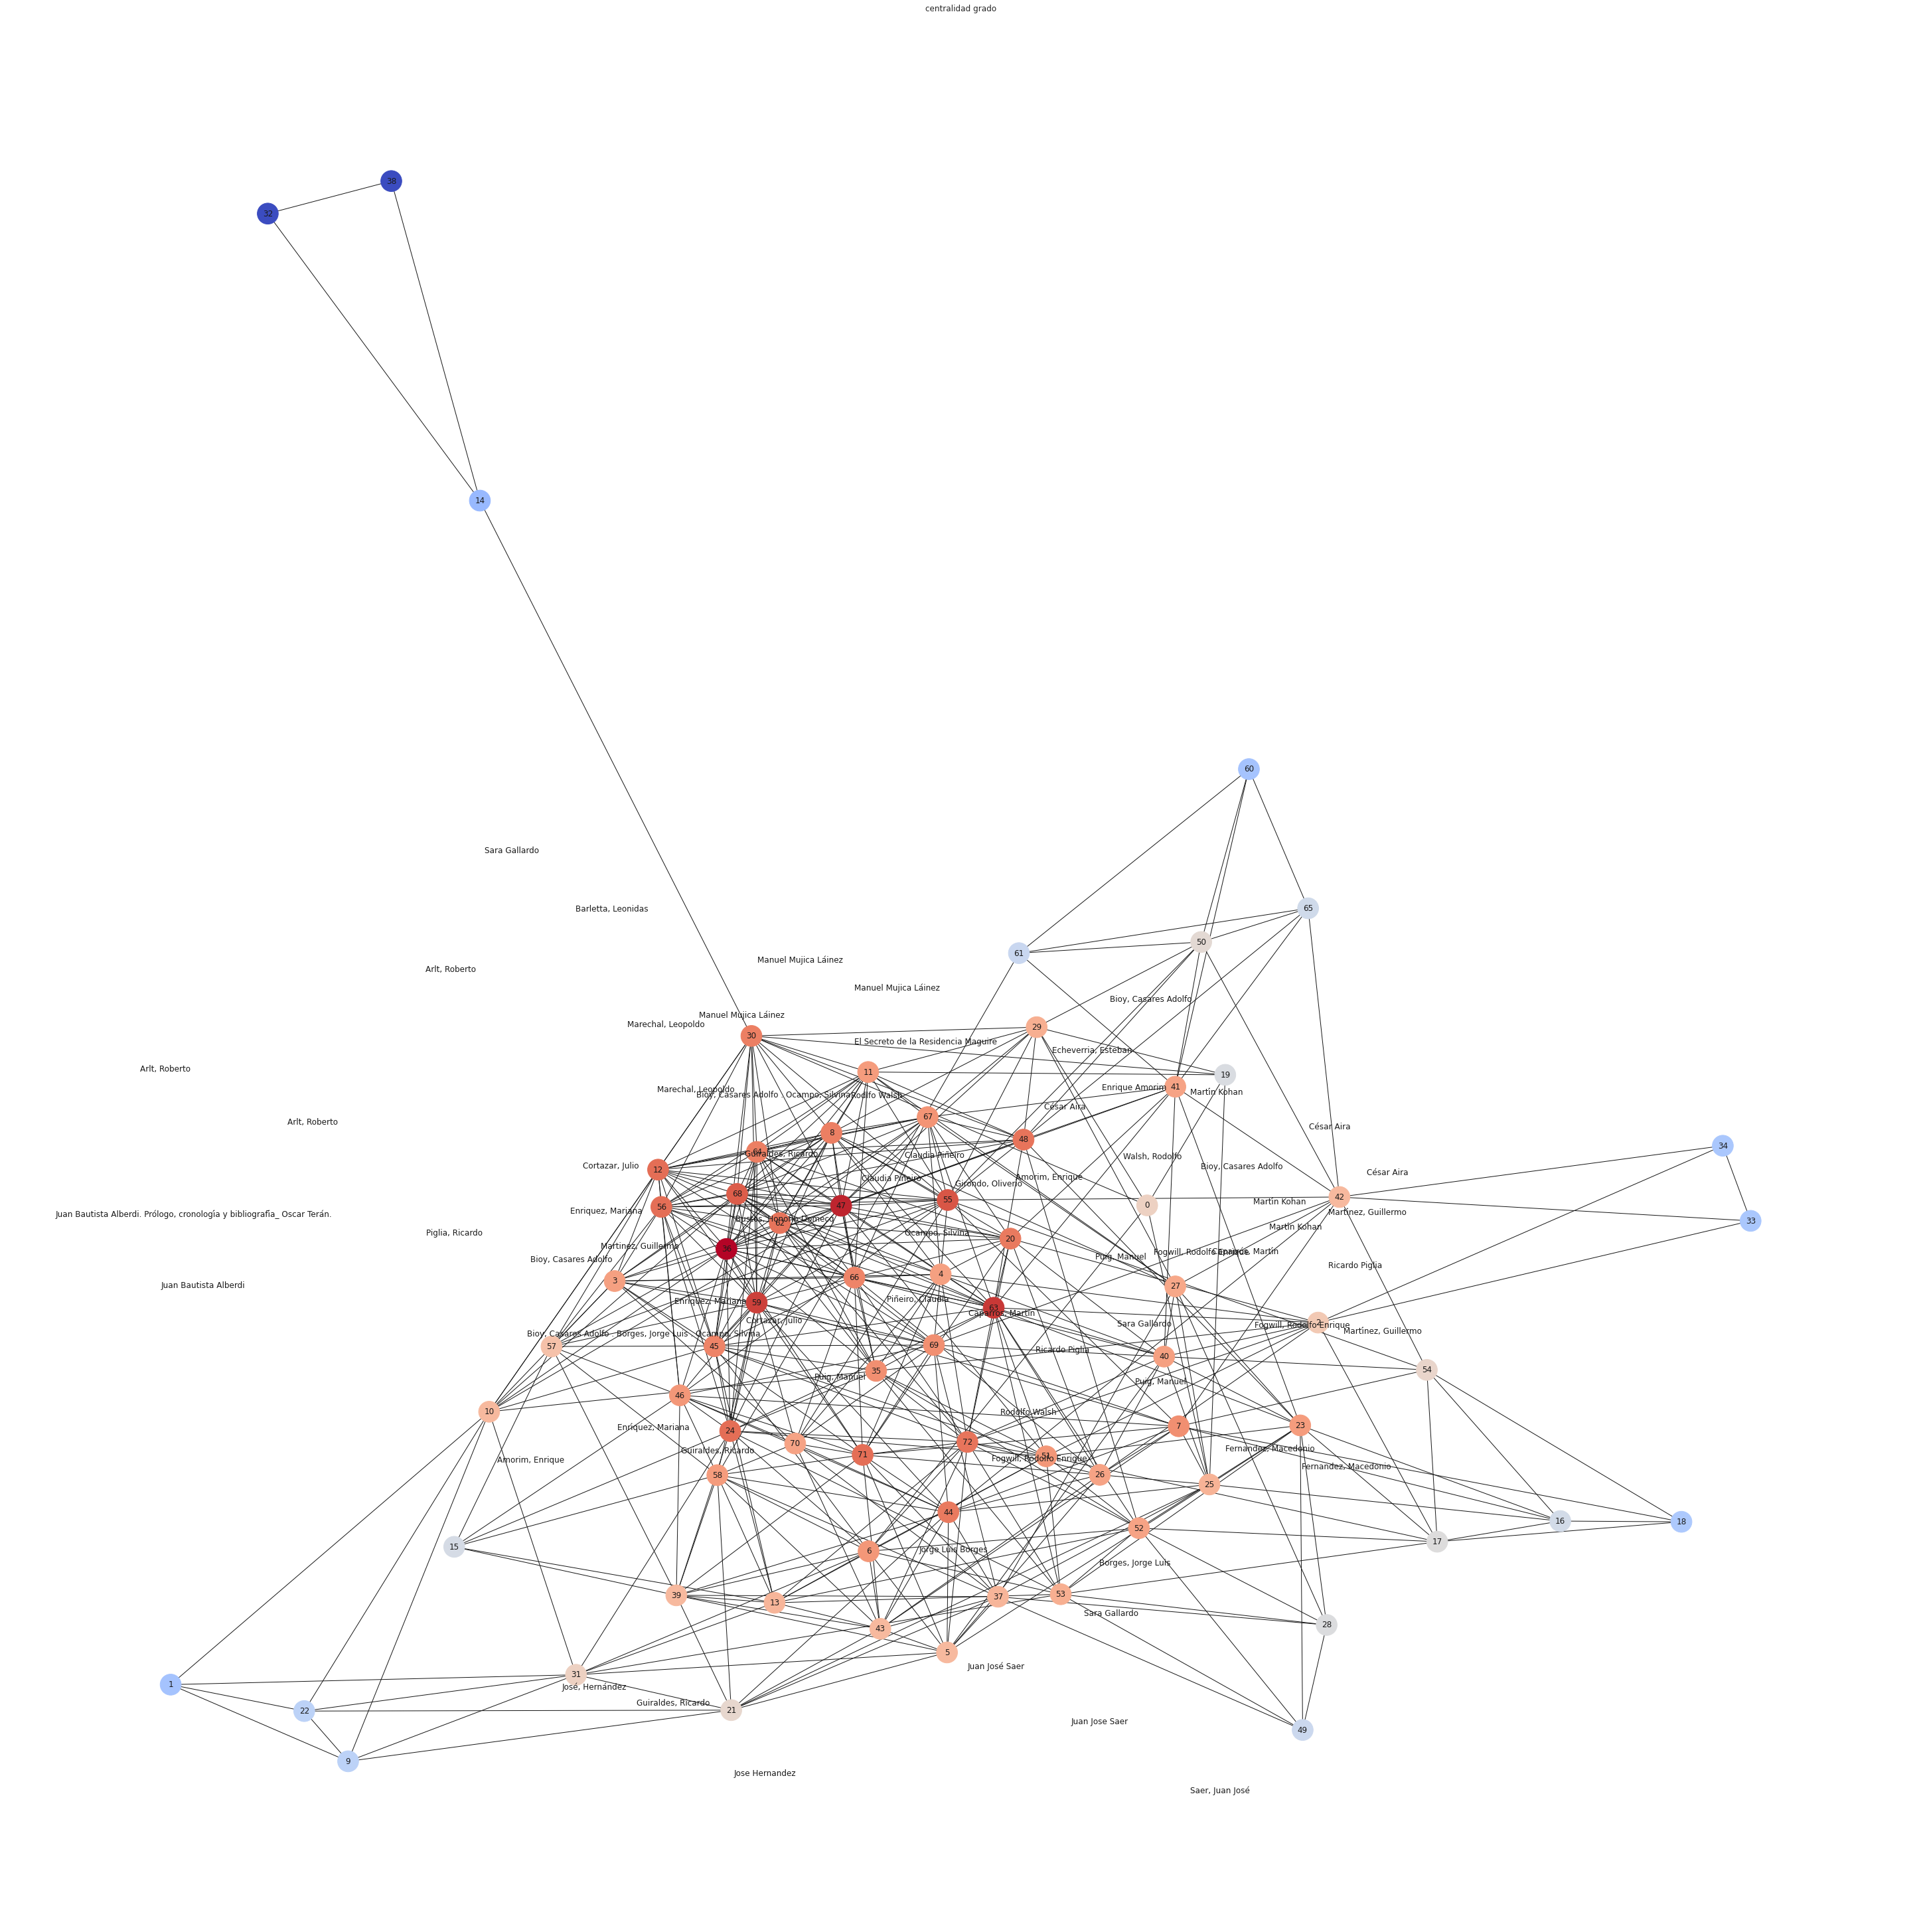

In [16]:

color_lookup=diccionario_centralidad_cercania
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)

rcParams['figure.figsize'] = 40, 40
nx.draw(G, 
        nodelist=color_lookup,
        node_size=1000,
        node_color=[mapper.to_rgba(i) 
                    for i in color_lookup.values()], 
        with_labels=True)
nx.draw_networkx_labels(G, pos, labels_autores, font_size=12)
plt.title('centralidad grado')
plt.show()

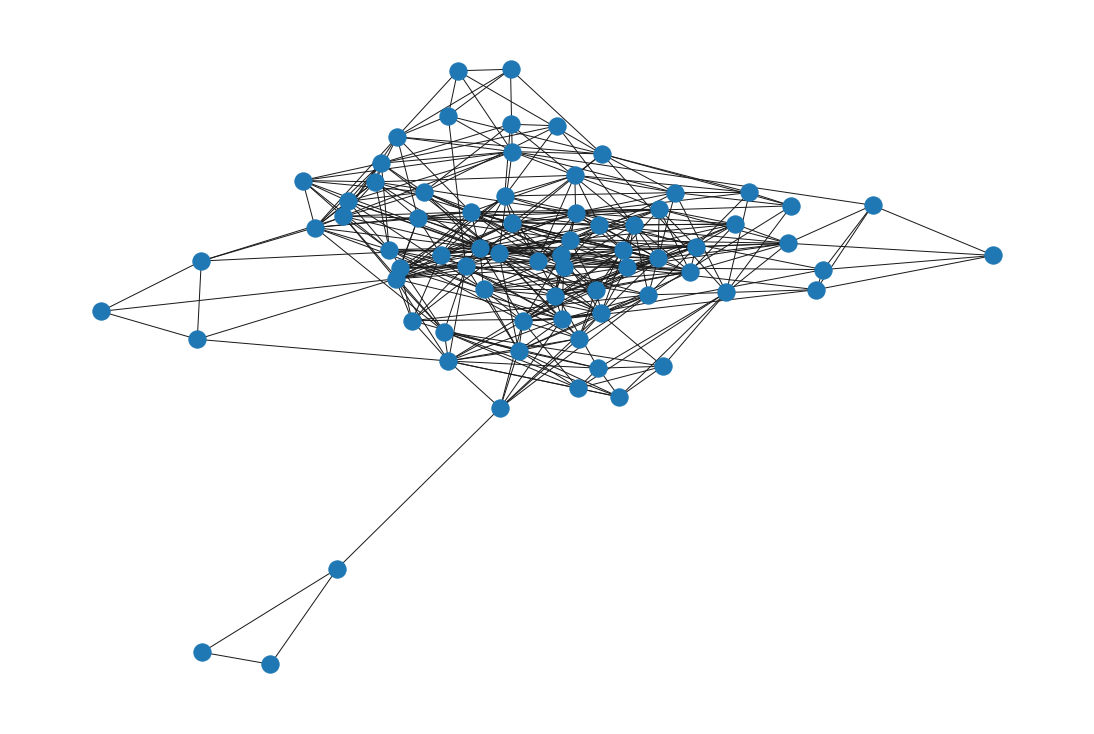

In [ ]:
def armar_componente_gigante(Red):
  Conjunto_nodos_en_gigante = max(nx.connected_components(Red), key=len)
  Componente_Gigante = Red.subgraph(Conjunto_nodos_en_gigante).copy()
  return Componente_Gigante

nx.draw(armar_componente_gigante(G))